# Fraud detection pipeline using Graph Neural Network

### Content
1. Introduction
1. Load transaction data
2. Graph construction
3. GraphSage training
5. Classifiction and Prediction
6. Evaluation
7. Conclusion

### 1. Introduction
This workflow shows an application of a graph neural network for fraud detection in a credit card transaction graph. We use a transaction dataset that includes three types of nodes, `transaction`, `client`, and `merchant` nodes. We use `GraphSAGE` along `XGBoost` to identify frauds in transactions. Since the graph is heterogenous we employ HinSAGE a heterogenous implementation of GraphSAGE.

First, GraphSAGE is trained separately to produce embedding of transaction nodes, then the embedding is fed to `XGBoost` classifier to identify fraud and nonfraud transactions. During the inference stage,  an embedding for a new transaction is computed from the trained GraphSAGE model and then feed to XGBoost model to get the anomaly scores.

### 2. Loading the Credit Card Transaction Data

In [86]:
#!pip install stellargraph

In [18]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#from HinSAGE import HinSAGE_Representation_Learner
from evaluation import Evaluation
from HinSAGE import HinSAGE_Representation_Learner
from stellargraph import StellarGraph
import networkx as nx
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# set seed 
np.random.seed(1001)
tf.random.set_seed(1001)

##### Load traing and test dataset

In [67]:
# Replace training-data.csv and validation-data.csv with training & validation csv in dataset file.
TRAINING_DATA ='../../datasets/training-data/fraud-detection-training-data.csv'
VALIDATION_DATA = '../../datasets/validation-data/fraud-detection-validation-data.csv'
train_data = pd.read_csv(TRAINING_DATA)
inductive_data = pd.read_csv(VALIDATION_DATA)

In [68]:
train_data.head(5)

,index,1000,1001,client_node,merchant_node,1004,1005,1006,1007,1008,...,1104,1105,1106,1107,1108,1109,1110,1111,1112,fraud_label
0,0,487.50,1,58744,91818,100499,1,1,8,9,...,0,0,0,0,0,0,0,0,0,1
1,1,1191.97,1,62913,91951,100532,1,1,9,23,...,0,0,0,0,0,0,0,0,0,0
2,2,231.79,0,72066,100382,100530,1,1,15,57,...,0,0,0,0,0,0,0,0,0,1
3,3,12.35,0,71679,96509,100809,1,1,11,23,...,0,0,0,0,1,0,0,0,0,1
4,4,58.37,0,71749,91760,100484,1,1,11,24,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# Set index to transaction id 
train_data.index = train_data['index']
inductive_data.index = inductive_data['index']

Since the number of samples of training data is small we augment data using benign transaction examples from the original training samples. This increase the number of benign example and reduce the proportion of fraud label transactions. This in similar to practical situation where fraud labels are few in proportion.

In [70]:
# Increase number of samples.
def augement_data(train_data=train_data, n=20):
    max_id = inductive_data.index.max()
    non_fraud = train_data[train_data['fraud_label'] == 0]
    
    non_fraud = non_fraud.drop(['index'], axis=1)
    df_fraud = pd.concat([non_fraud for i in range(n)])
    df_fraud.index = np.arange(1076, 1076 + df_fraud.shape[0])
    df_fraud['index'] = df_fraud.index
    
    return pd.concat((train_data, df_fraud))

In [71]:
train_data = augement_data(train_data, n=20)

The `train_data` variable stores the data that will be used to construct graphs on which the representation learners can train. 
The `inductive_data` will be used to test the inductive performance of our representation learning algorithms.

In [72]:
print('The distribution of fraud for the train data is:\n', train_data['fraud_label'].value_counts())
print('The distribution of fraud for the inductive data is:\n', inductive_data['fraud_label'].value_counts())

The distribution of fraud for the train data is:
 0    11865
1      188
Name: fraud_label, dtype: int64
The distribution of fraud for the inductive data is:
 0    244
1     21
Name: fraud_label, dtype: int64


### 3. Construct transasction graph network

Here, nodes, edges, and features are passed to the `graph_construction` method. Note that client and merchant node data hold a dummy attribute with value 1. This is because we want all the relevant transaction data to reside at the transaction nodes and StellarGraph's current HinSAGE implementation requires all nodes to have features.

In [73]:
def graph_construction(nodes, edges, node_features):
    g_nx = nx.Graph()
    # add nodes
    for key, values in nodes.items():
        g_nx.add_nodes_from(values, ntype=key)
    # add edges
    for edge in edges:
        g_nx.add_edges_from(edge)

    return StellarGraph(g_nx, node_type_name="ntype", node_features=node_features)

In [74]:
def build_graph_features(dataset):
    # Build graph features
    transaction_node_data = dataset.drop(["client_node","merchant_node","fraud_label", "index"], axis=1)
    #transaction_node_data = (transaction_node_data - transaction_node_data.mean(0)) / (0.0001 + transaction_node_data.std(0))
    client_node_data = pd.DataFrame([1]*len(dataset.client_node.unique())).set_index(dataset.client_node.unique())
    merchant_node_data = pd.DataFrame([1]*len(dataset.merchant_node.unique())).set_index(dataset.merchant_node.unique())

    nodes = {"client":dataset.client_node, "merchant":dataset.merchant_node, "transaction":dataset.index}
    edges = [zip(dataset.client_node, dataset.index),zip(dataset.merchant_node, dataset.index)]
    features = {"transaction": transaction_node_data, 'client': client_node_data, 'merchant': merchant_node_data}
    graph = graph_construction(nodes, edges, features)
    return graph

In [75]:
G = build_graph_features(train_data) # Build graph using all dataset

/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  # Remove the CWD from sys.path while we load stuff.


In [76]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 13064, Edges: 24106

 Node types:
  transaction: [12053]
    Features: float32 vector, length 111
    Edge types: transaction-default->client, transaction-default->merchant
  client: [623]
    Features: float32 vector, length 1
    Edge types: client-default->transaction
  merchant: [388]
    Features: float32 vector, length 1
    Edge types: merchant-default->transaction

 Edge types:
    merchant-default->transaction: [12053]
        Weights: all 1 (default)
        Features: none
    client-default->transaction: [12053]
        Weights: all 1 (default)
        Features: none


### 4. Train Heterogeneous GraphSAGE

HinSAGE, a heterogeneous graph implementation of the GraphSAGE framework is trained with user specified hyperparameters. The model train several GraphSAGE models on the type of relationship between different types of nodes.

In [47]:
# Hyper parameters to GraphSAGE
embedding_size = 64
num_samples = [2,32]
embedding_node_type = "transaction"
hinsage = HinSAGE_Representation_Learner(embedding_size, num_samples, embedding_node_type)
trained_hinsage_model, train_embedding = hinsage.train_hinsage(G, list(train_data.index), train_data['fraud_label'], batch_size=1000, epochs=10)

/opt/conda/envs/rapids/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
10/10 [==============================] - 12s 1s/step - loss: 0.6418 - val_loss: 0.5367
Epoch 2/10
10/10 [==============================] - 10s 990ms/step - loss: 0.4832 - val_loss: 0.4006
Epoch 3/10
10/10 [==============================] - 10s 975ms/step - loss: 0.3759 - val_loss: 0.3133
Epoch 4/10
10/10 [==============================] - 10s 967ms/step - loss: 0.3092 - val_loss: 0.2587
Epoch 5/10
10/10 [==============================] - 10s 1s/step - loss: 0.2674 - val_loss: 0.2234
Epoch 6/10
10/10 [==============================] - 10s 971ms/step - loss: 0.2401 - val_loss: 0.1987
Epoch 7/10
10/10 [==============================] - 10s 971ms/step - loss: 0.2207 - val_loss: 0.1802
Epoch 8/10
10/10 [==============================] - 10s 979ms/step - loss: 0.2060 - val_loss: 0.1657
Epoch 9/10
10/10 [==============================] - 10s 1s/step - loss: 0.1944 - val_loss: 0.1537
Epoch 10/10
10/10 [==============================] - 10s 980ms/step - loss: 0.1848 - val_loss: 0.143

### 4.2 Inductive Step GraphSAGE

In this part, we want to compute the inductive embedding of a new transaction. To extract the embedding of the new transactions, we need to keep indices of the original graph nodes along with the new transaction nodes. We need to concatenate the test data frame to the train data frame to create a new graph that includes all nodes.

In [77]:
pd.options.mode.chained_assignment = None
inductive_graph_data = pd.concat((train_data, inductive_data))
inductive_graph_data = inductive_graph_data.set_index(inductive_graph_data['index'])#.drop("index",axis = 1)

For the inductive step, we need to add the new, unseen transactions to the graph. Because the current StellarGraph implementation does not support adding nodes and edges to an existing stellargraph object, we create a new graph that contains all the nodes from the train graph in addition to the new nodes.

In [78]:
G_test = build_graph_features(inductive_graph_data)
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 13661, Edges: 24636

 Node types:
  transaction: [12318]
    Features: float32 vector, length 111
    Edge types: transaction-default->client, transaction-default->merchant
  client: [861]
    Features: float32 vector, length 1
    Edge types: client-default->transaction
  merchant: [482]
    Features: float32 vector, length 1
    Edge types: merchant-default->transaction

 Edge types:
    merchant-default->transaction: [12318]
        Weights: all 1 (default)
        Features: none
    client-default->transaction: [12318]
        Weights: all 1 (default)
        Features: none


/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  # Remove the CWD from sys.path while we load stuff.


The inductive step applies the previously learned (and optimized) aggregation functions, part of the `trained_hinsage_model`. We also pass the new graph G_test and the node identifiers (inductive_data.index) to the inductive step. 

In [79]:
inductive_embedding = hinsage.inductive_step_hinsage(G_test, trained_hinsage_model, inductive_data.index, batch_size=5)

53/53 [==============================] - 1s 8ms/step


### 5. Classification: predictions based on inductive embeddings

Now a selected classifier (XGBoost) can be trained using the training node embedding and test on the test node embedding.

In [80]:
from xgboost import XGBClassifier

classifier = XGBClassifier(n_estimators=100)

If requested, the original transaction features are added to the generated embeddings. If these features are added, a baseline consisting of only these features (without embeddings) is included to analyze the net impact of embeddings on the predictive performance.

In [81]:
col_drop = ["fraud_label"]
train_labels = train_data['fraud_label']

baseline_train = train_data.drop(col_drop, axis=1)
baseline_inductive = inductive_data.drop(col_drop, axis=1)

classifier.fit(baseline_train, train_labels)
baseline_predictions = classifier.predict_proba(baseline_inductive)
    
classifier.fit(train_embedding, train_labels)
predictions = classifier.predict_proba(inductive_embedding)


/opt/conda/envs/rapids/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:09] WARNING: /rapids/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:09] WARNING: /rapids/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 6. Evaluation

Given the highly imbalanced nature of our dataset, we evaluate the results based on precision-recall and ROC curves.

Average precision-recall score for  GraphSAGE+features  configuration XGBoost: 0.8021196111
Average precision-recall score for  Baseline  configuration XGBoost: 0.4552021575


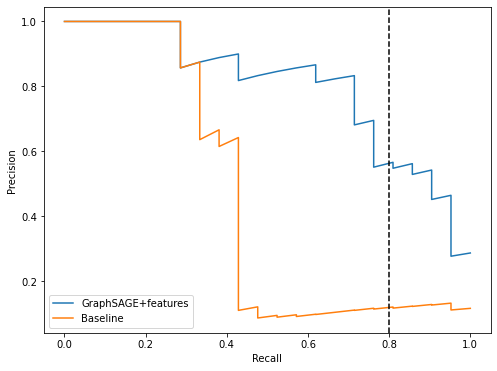

In [84]:
#from inductiveGRL.evaluation import Evaluation
inductive_labels = inductive_data['fraud_label'] #df.loc[inductive_emb.index]['fraud_label']
plt.figure(figsize=(8, 6))
graphsage_evaluation = Evaluation(predictions, inductive_labels, "GraphSAGE+features") 
graphsage_evaluation.pr_curve()

#if add_additional_data is True:

baseline_evaluation = Evaluation(baseline_predictions, inductive_labels, "Baseline")
baseline_evaluation.pr_curve()
plt.axvline(x=0.8, color='k', linestyle='--')

ROC score for  GraphSAGE+features  configuration : 0.9720000000
ROC score for  Baseline  configuration : 0.7190000000


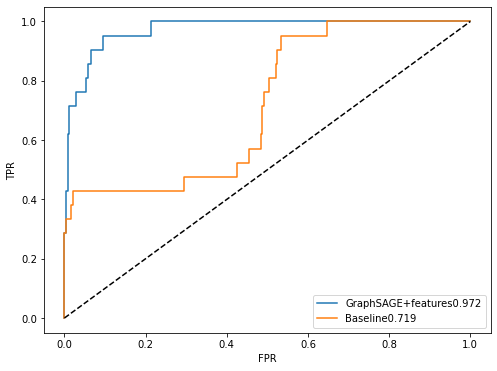

In [85]:
plt.figure(figsize=(8, 6))
graphsage_evaluation.roc_curve()
baseline_evaluation.roc_curve()
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1),'k--')

The result show, using GNN embedded features achieves better peformance compared to the XGBoost trained on raw features. We see a significant improvement in precision and recall over the GNN on raw features.

### 6.2 Save models

We can save the two trained models, a graphsage and xgboost into their respective save format. For infernce, graphsage is loaded as tensorflow model, and the XGBoost is loaded using `cuml` *Forest Inference Library (FIL)*.

In [30]:
model_dir= "model/"
#model = {}
graph_sage_model = os.path.join(model_dir, 'fd_graphsage.pth')
xgb_model = os.path.join(model_dir, 'xgb.pth')
trained_hinsage_model.save(output_hinsage)
classifier.save_model(output_xgboost)

In [52]:
## For inference we can load from file as follows. 
from cuml import ForestInference

graph_sage = tf.keras.models.load_model(graph_sage_model)
fm = ForestInference.load(xgb_model, output_class=True)

# do inference on loaded models.

### 7. Conclusion

In this workflow, we show a hybrid approach how to use Graph Neural network along XGBoost for a fraud detection on credit card transaction network. For further, optimized inference pipeline refer to `Morpheus` inference pipeline of fraud detection.

### Reference
1. Van Belle, Rafaël, et al. "Inductive Graph Representation Learning for fraud detection." Expert Systems with Applications (2022): 116463.
2.https://stellargraph.readthedocs.io/en/stable/hinsage.html?highlight=hinsage
3.https://github.com/rapidsai/clx/blob/branch-0.20/examples/forest_inference/xgboost_training.ipynb"